In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm 
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from time import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
"""Load the datasets."""
images = loadmat('images.mat') 
classes = loadmat('classes')

images=images['images'].T  
classes=classes['classes'].T

In [12]:
#replace images and classes with light_images and light_classes for co
X_train, X_test, y_train, y_test = train_test_split(images, classes, test_size=0.3, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1689, 32256)
(1689, 1)
(725, 32256)
(725, 1)


In [13]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

In [14]:
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt

# Initialize the PCA model
pca = decomposition.PCA(n_components=200, whiten=True)

# Fit the PCA model to the training data
pca.fit(X_train_std)

PCA(n_components=200, whiten=True)

PCA-transformed training data shape: (1689, 200)
PCA-transformed test data shape: (725, 200)


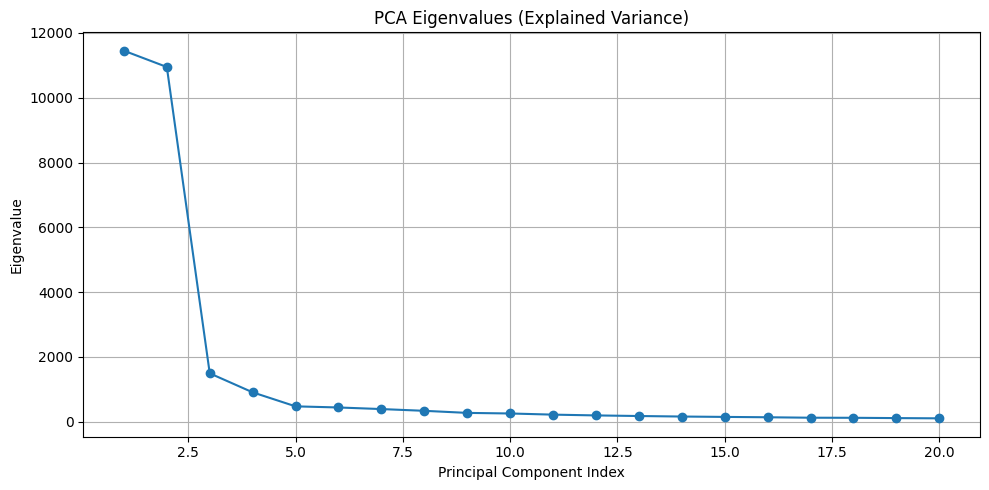

In [15]:
# Transform the training and test data to get the PCA components
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(f"PCA-transformed training data shape: {X_train_pca.shape}")
print(f"PCA-transformed test data shape: {X_test_pca.shape}")

# Visualize the explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 21), pca.explained_variance_[:20], marker='o')
plt.title("PCA Eigenvalues (Explained Variance)")
plt.xlabel("Principal Component Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import f1_score
from sklearn.base import RegressorMixin
import numpy as np
import matplotlib.pyplot as plt

def compute_f1_scores(X_train_pca, X_test_pca, y_train, y_test, clf=None):
    # Define the range of PCA components to try
    components_range = np.arange(5, 101, 5)
    f1_scores = []

    # For each number of components
    for n_components in components_range:
        # Use only the first n_components from the PCA-transformed data
        X_train_subset = X_train_pca[:, :n_components]
        X_test_subset = X_test_pca[:, :n_components]
        
        if clf is None:
            n_classes = len(np.unique(y_train))
            Y_train_ova = np.zeros((X_train_subset.shape[0], n_classes))

            X_aug = np.hstack([X_train_subset, np.ones((X_train_subset.shape[0], 1))])
            X_test_aug = np.hstack([X_test_subset, np.ones((X_test_subset.shape[0], 1))])

            W = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ Y_train_ova
            Y_pred_scores = X_test_aug @ W
            y_pred = np.argmax(Y_pred_scores, axis=1) + 1
        else:
            # Train the classifier
            clf.fit(X_train_subset, y_train.ravel())
            
            # Get predictions
            raw_predictions = clf.predict(X_test_subset)
        
            y_pred = raw_predictions
        
        # Calculate F1 score
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

    return components_range, f1_scores

In [17]:
components_range_lin_reg, f1_scores_lin_reg = compute_f1_scores(X_train_pca, X_test_pca, y_train, y_test)

In [18]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='rbf', gamma='scale')
components_range_svm, f1_scores_svm = compute_f1_scores(X_train_pca, X_test_pca, y_train, y_test, svm_clf)

In [19]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=2000, fit_intercept=True)
components_range_log_reg, f1_scores_log_reg = compute_f1_scores(X_train_pca, X_test_pca, y_train, y_test, log_reg)

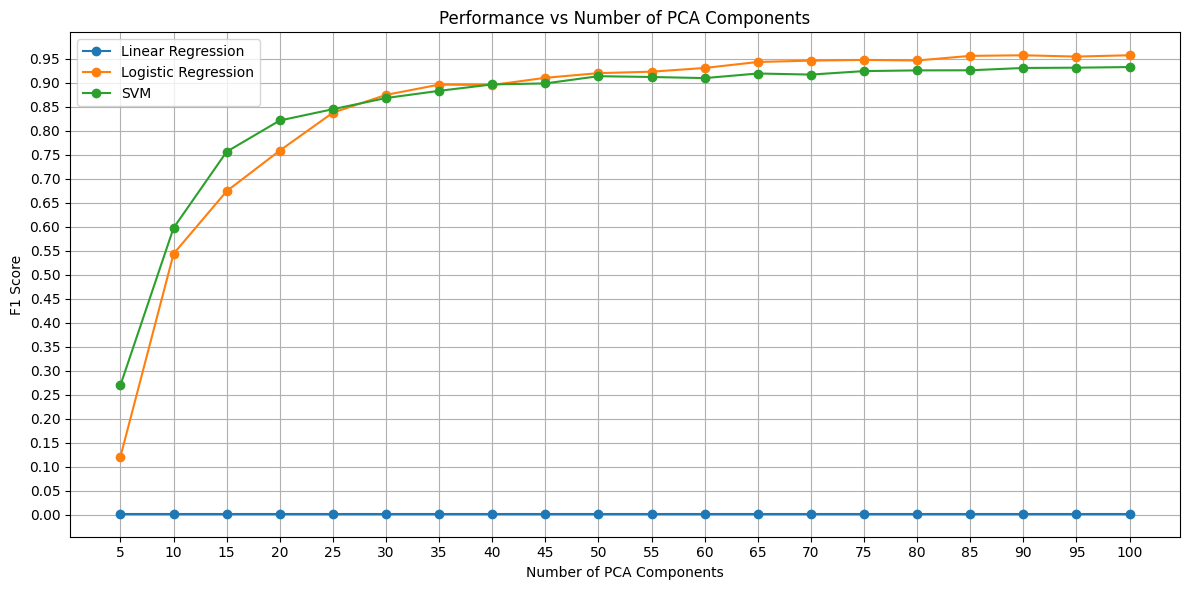

In [ ]:

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(components_range_log_reg, f1_scores_log_reg, marker='o', linestyle='-')
plt.plot(components_range_svm, f1_scores_svm, marker='o', linestyle='-')
plt.title("Performance vs Number of PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("F1 Score")
plt.legend(['Logistic Regression', 'SVM'])
plt.grid(True)
plt.xticks(np.arange(5, 101, 5))
plt.yticks(np.arange(0, 1, 0.05))
plt.tight_layout()
plt.show()

In [21]:
n_classes = len(np.unique(y_train))
Y_train_ova = np.zeros((X_train_pca.shape[0], n_classes))

for idx, cls in enumerate(np.unique(y_train)):
    Y_train_ova[:, idx] = (y_train == cls).flatten().astype(float)

# Add bias column to X
X_aug = np.hstack([X_train_pca])  # shape: (N, d+1)

# Solve for W: shape (d+1, n_classes)
W = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ Y_train_ova

In [22]:
X_test_aug = np.hstack([X_test_pca])  # shape: (N_test, d+1)
Y_pred_scores = X_test_aug @ W  # shape: (N_test, n_classes)

y_pred = np.argmax(Y_pred_scores, axis=1) + 1

Accuracy: 0.953103448275862
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        23
           2       0.93      1.00      0.96        13
           3       1.00      0.83      0.91        18
           4       0.89      0.85      0.87        20
           5       0.96      0.96      0.96        23
           6       0.85      1.00      0.92        11
           7       1.00      0.86      0.92        21
           8       1.00      1.00      1.00        22
           9       1.00      0.96      0.98        24
          10       1.00      0.89      0.94        18
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        22
          13       1.00      0.94      0.97        18
          14       0.93      1.00      0.97        14
          15       0.89      1.00      0.94        24
          16       0.92      0.96      0.94        25
          17       1.00      1.00      1.00        21

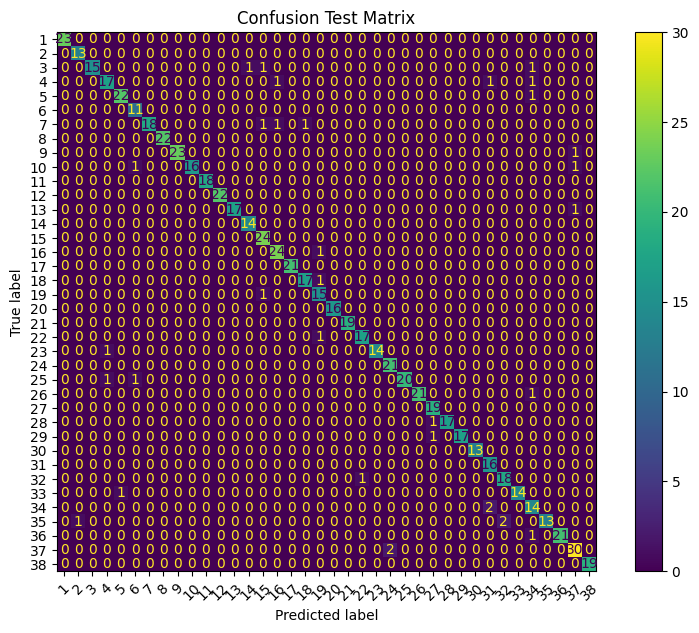

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis', xticks_rotation=45)
disp.figure_.set_size_inches(10, 7)  # directly change the size
plt.title("Confusion Test Matrix")
plt.grid(False)
plt.show()